<a href="https://colab.research.google.com/github/iciromaco/RadiShLab/blob/master/S6_%E3%83%99%E3%82%B8%E3%82%A8%E6%9B%B2%E7%B7%9A%E3%81%82%E3%81%A6%E3%81%AF%E3%82%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# N006 ベジエ曲線のあてはめ

In [1]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial
from sympy.abc import a,b,c
# init_session()
from sympy import var
# px,py =var('px:4'),var('py:4')

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/My Drive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdlib4 as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

輪郭線の画素数は、左 321  右314


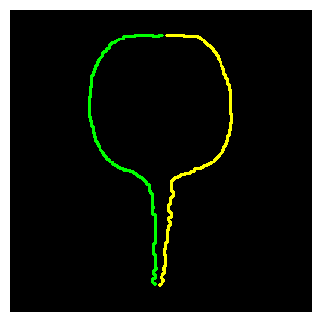

In [2]:
# 画像の左右の輪郭線を抽出　（N005参照）
img = imgs[4]
conLeft,conRight = rd.getCntPairWithImg(img,dtopdr=1,dbtmdr=1)
canvas = cv2.cvtColor(np.zeros_like(img) ,cv2.COLOR_GRAY2BGR)
rd.drawContours(canvas,conLeft,color=(0,255,0),thickness=2)
rd.drawContours(canvas,conRight,color=(0,255,255),thickness=2)
plt.figure(dpi=100)
rd.plotimg(canvas)
print("輪郭線の画素数は、左 {}  右{}".format(len(conLeft),len(conRight)))

輪郭線を構成する画素の数は、この例で左右それぞれ300画素近い。

## **getSamples()**
> **rd.getSamples(cont,N=20,mode='Equidistant')**  
    > 入力  
    > 　**cont** 輪郭線構造体 開いた輪郭線を想定している  
    > 　**N** サンプル数  
    > パラメータ  
    >　 **mode = 'Equidistant'**  始点からの距離について等間隔 (default)  
    > 　**mode = 'Simple'**  単純にインデックスを等間隔

ディジタル画像は斜め方向と上下左右とで画素間の距離が異なるので、単純にインデックスを等間隔に刻むと、輪郭が斜めになっている部分と縦横に伸びている部分とでサンプリング間隔が変化してしまう。

曲線あてはめにはそれほど影響しないが、気にする場合は **Equidistant**を用いるとよい。

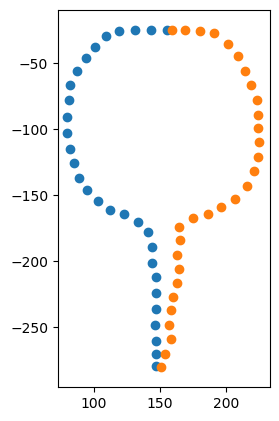

In [3]:
Left = rd.getSamples(conLeft,N=30,mode='Equidistant')
Right = rd.getSamples(conRight,N=30,mode='Simple')

plt.figure(figsize=(5,5),dpi=100)
g = plt.subplot()
g.set_aspect('equal')
plt.scatter(Left[:,0],-Left[:,1])
plt.scatter(Right[:,0],-Right[:,1]);

左が距離等間隔、右がインデックスの等間隔

# ベジエ曲線のあてはめ

- 標本点 $samples[i]$ と同じ数だけの点をベジエ曲線上に設定し、たがいを紐づける。ベジエ曲線上の点$P[i]$はパラメータ $t[i]$ だけで特定される。つまり、$P[i]=Bez(t[i])$ と書ける。
- 目的関数を$\|samples[i]-Bez[t[i]]\|$とし、これを最小化するような 関数$Bez()$を見つけることが目的である。
- ベジエ曲線は$N+1$個の制御点で規定されるので、もし $t[i]$ が既知であるならば、未知数　$2(N+1)$個 の最適化問題である。しかし、実際には $t[i]$ はわからない。
- 逆にベジエ曲線の制御点が分かっているならば、未知数は $t[i]$ であり、ベジエ曲線上で各標本点の最寄りの点を探す問題となる。
- 実際にはいずれも未知であるのですべて連立させて最適化しないといけないが一度に求める解析的な方法はありそうにない。そこで、ここでは緩和法的なアルゴリズムを用いて解決する。

### 漸近的ベジエフィッティングアルゴリズム

> **fit0()**  
> パラメータを固定して評価関数が最小化されるような制御点を求めることで、暫定的なベジエ近似曲線の表現式を得るプログラム   
> **refineTparaN()**  
>  暫定的なベジエ近似曲線に対し、各標本点に対して紐づけられていたパラメータの示す位置よりより近い曲線上の点のパラメータをサーチしてパラメータを再紐づけするプログラム。  
> 標本点の間隔が広い場合はそれぞれの標本点から最短の点を見つけるというやり方でよいが、標本点が密になるとその方法では順序関係に矛盾が生じる可能性がある。そこで、前後の点に紐づいたパラメータ間で最も近い点のパラメータによりパラメータを更新する、という操作を一定回数繰り返す。

> **fit1()**  fit0() と refineTparaN() を繰り返すことでフィッティングを行うプログラム。

以上の関数を持つクラス、BezierCurve を用意した。

---

## class BezierCurve:
> クラス変数  
>> **driftThres** = 0.03 # 繰り返しの終了を決定するパラメータ変動幅の平均値に対するしきい値  
>> **errorThres** = 0.01  # 繰り返しの終了を決定するエラー変動のしきい値  
>> **dCount** = 5        # ２分探索の打ち切り回数  
>> **debugmode** = False  # デバッグ情報の表示オンオフ  
>> **openmode** = False  # 端点をサンプルに強制吸着するか否か  
>> **AsymptoticPriority** = 'distance' # パラメータ割り当てのフェーズで距離（'distance'）を尺度とするか、等間隔配置（'span'）を評価尺度とするか

## **BezierCurve()**　（コンストラクタ）
> **rd.BezierCurve(self, N=5, samples = [], initialPara=[])**  
>入力
>>    **samples**   輪郭の標本  
>>    **N**  ベジエ曲線の次数  
>>    **initialPara**   サンプルに対するベジエ関数のパラメータの初期値
>>                  デフォルトは[]であり、その場合は初期値はリニアとなる
    
> **bez = BezierCurve(N=5,con)**

## **bez.fit0()**  高速あてはめ
>> 標本点に対応するベジエ曲線上の対応点のパラメータがパラメータ空間で等間隔であると仮定してあてはめを実行する。繰り返しをしないので高速。

##  **bez.fit1(maxTry=0)**　厳密あてはめ
>> maxTry 最大繰り返し回数　0の場合は収束条件を満たすまで繰り返す   
>> Step1  fit0() の実行      
>> Setp2  fit0()で求めた曲線をもとに、標本点に対応するパラメータを再計算する  
>>（前回の仮のパラメータが示す位置よりもより近い曲線上の点を見つけ、紐づけるパラメータを更新する）

## **toggledebugmode(set=True,debug=False)**   デバッグ情報のオンオフ
>>  **set** True/セットする、False/トグルする  
>>  **debug** True/誤差表示あり、False/誤差表示なし

## **setParameters(driftThres=0.03,errorThres=0.01,dCount=5,debugmode=False,openmode=False)**  パラメータの表示とセット

> クラス変数
>>**driftThres** = 0.03 # 繰り返しにおけるパラメータ変動幅の平均値に対するしきい値。  
>>**errorThres** = 0.01 # 繰り返し打ち切りを決める変動幅のしきい値。 
     パラメータと誤差の変動幅がともにしきい値より小さくなったら計算を打ち切る。



lengths = [10,12,21,23,24,32,34,35,40,41,42,51]
searchfor = [10,20,30,40,50]
# 結果の描画

##  **drawBez()**
> **drawBez(rdimg,bezL=None,bezR=None,bezC=None,cpl=None,cpr=None,cpc=None, 
             cntL=[],cntR=[],cntC=None, ladder=None,PosL=[],PosR=[],PosC=[],n_samples=20,saveImage=False,savepath="",ct=[])**
             
>入力  
>>    **rdimg**  シルエット画像  
>>    **bezL**,**bezR**,**bezC**   ベジエ曲線の定義式　3本まで描ける  
>>    **cpl**,**cpr**,**cpc**     ベジエ曲線の制御点    
>>    **cntL**,**cntR**,**cntC**  標本点
>>    **PosL**,**PosR**.**PosC** ラダーの設置点
>パラメータ  
>>    **ladder**  標本点間を結ぶ線分を描画するかどうか    
>>    **n_samples**  ラダーの数  
>>    **saveImage** 画像を保存するかどうか  
>>    **savepath** ファイル名  
>>    **ct** カラー指定　説明省略
    

# 実行例

### 現在のパラメータ設定の表示

In [4]:
rd.BezierCurve.setParameters()

AsymptoticPriority :  distance
dCount    :  7
driftThres:  0.03
errorThres:  0.01
debugmode :  False
openmode  :  False



## 高速フィッテイング fit0()の実行例 
 4次ベジエ近似、not openmode ( 端点固定 ）



Wall time: 2.93 s


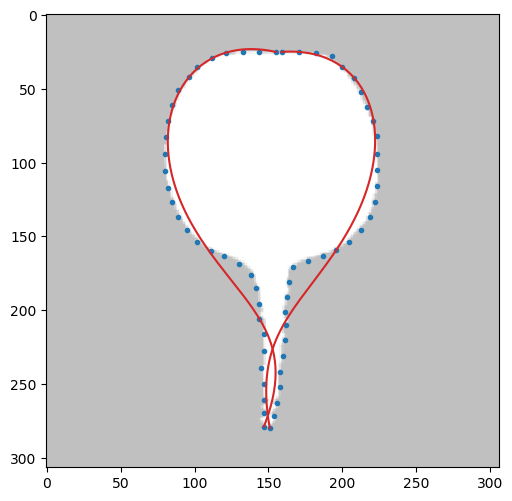

In [5]:
%%time
# 先にもとめた左右の輪郭線からそれぞれ等間隔で32個ずつ標本点を取ってくる
cntL = rd.getSamples(conLeft,N=32)
cntR = rd.getSamples(conRight,N=32)
# ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
bezL = rd.BezierCurve(N=4,samples=cntL)
bezR = rd.BezierCurve(N=4,samples=cntR)

# rd.BezierCurve.toggledebugmode(set=True,debug=True)
# 高速あてはめの実行
cpsL0,fL0 = bezL.fit0()
cpsR0,fR0 = bezR.fit0()
# 結果の描画
rd.drawBez(img,stt=0.00,end=1.0,bezL=fL0,bezR=fR0,cntL=cntL,cntR=cntR)

## 得られたベジエ曲線の定義式

In [6]:
fL0,fR0

(Matrix([
 [147.0*t**4 + 192.551601533388*t**3*(4 - 4*t) + 265.077082808181*t**2*(1 - t)**2 + 175.806130003696*t*(1 - t)**3 + 155.0*(1 - t)**4],
 [ 279.0*t**4 + 162.458984179697*t**3*(4 - 4*t) + 1204.80073305912*t**2*(1 - t)**2 + 1.11597324728571*t*(1 - t)**3 + 25.0*(1 - t)**4]]),
 Matrix([
 [151.0*t**4 + 130.577662073419*t**3*(4 - 4*t) + 1395.67869808753*t**2*(1 - t)**2 + 1083.84412108958*t*(1 - t)**3 + 159.0*(1 - t)**4],
 [ 280.0*t**4 + 163.718975142896*t**3*(4 - 4*t) + 1228.11538060743*t**2*(1 - t)**2 + 68.7998882513331*t*(1 - t)**3 + 25.0*(1 - t)**4]]))

この式は sympy 形式で表現されており、次のような方法でパラメータ t に値を代入することができます。

In [7]:
fL0.subs('t',0.5)  # fL の t に 0.5 を代入　（左輪郭の中間点の座標） 

Matrix([
[94.5681011840893],
[134.984540189074]])

sympy は数式処理ライブラリですので、具体値だけでなく、次のように式を代入することも可能です。

In [8]:
a,b = var('a,b')
fL0.subs('t',(a+b)**2).subs(a,3)  # t に a+b を代入し、さらに a に３を代入

Matrix([
[155.0*(1 - (b + 3)**2)**4 + 175.806130003696*(1 - (b + 3)**2)**3*(b + 3)**2 + 265.077082808181*(1 - (b + 3)**2)**2*(b + 3)**4 + 192.551601533388*(4 - 4*(b + 3)**2)*(b + 3)**6 + 147.0*(b + 3)**8],
[ 25.0*(1 - (b + 3)**2)**4 + 1.11597324728571*(1 - (b + 3)**2)**3*(b + 3)**2 + 1204.80073305912*(1 - (b + 3)**2)**2*(b + 3)**4 + 162.458984179697*(4 - 4*(b + 3)**2)*(b + 3)**6 + 279.0*(b + 3)**8]])

sympy の代入 subs は元の式に影響を与えません

In [9]:
fL0 # 代入前の式のままであることを確認せよ

Matrix([
[147.0*t**4 + 192.551601533388*t**3*(4 - 4*t) + 265.077082808181*t**2*(1 - t)**2 + 175.806130003696*t*(1 - t)**3 + 155.0*(1 - t)**4],
[ 279.0*t**4 + 162.458984179697*t**3*(4 - 4*t) + 1204.80073305912*t**2*(1 - t)**2 + 1.11597324728571*t*(1 - t)**3 + 25.0*(1 - t)**4]])

## 制御点の位置

In [10]:
cpsL0,cpsR0

([[155.0, 25.0],
  [43.951532500923875, 0.2789933118214269],
  [44.17951380136355, 200.80012217651978],
  [192.55160153338804, 162.4589841796966],
  [147.0, 279.0]],
 [[159.0, 25.0],
  [270.961030272394, 17.199972062833282],
  [232.61311634792196, 204.68589676790492],
  [130.57766207341928, 163.71897514289626],
  [151.0, 280.0]])

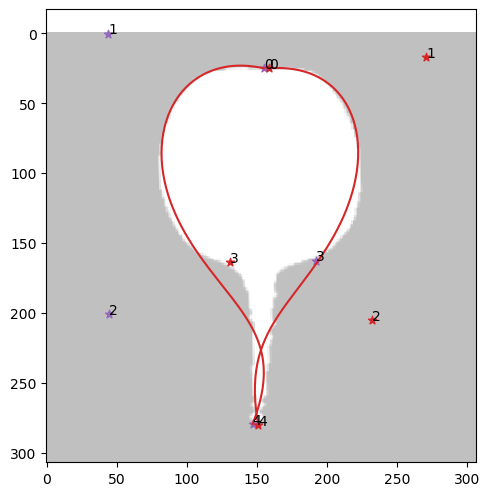

In [11]:
rd.drawBez(img,stt=0.00,end=1.0,bezL=fL0,bezR=fR0,cpl=cpsL0,cpr=cpsR0)

# Eager フィッティング fit1()の実行例
　４次近似  not openmode ( 端点固定 ）

.....................................
...................................
Wall time: 3min 38s


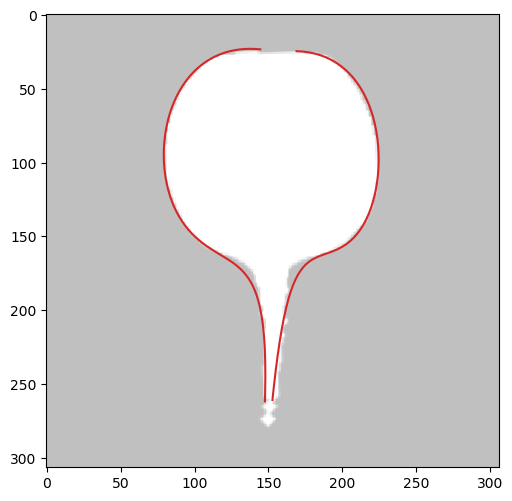

In [12]:
%%time
# rd.BezierCurve.toggledebugmode(set=True,debug=True)
# 先にもとめた左右の輪郭線からそれぞれ等間隔で32個ずつ標本点を取ってくる
# cntL = rd.getSamples(conLeft,N=32)
# cntR = rd.getSamples(conRight,N=32)
# ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
# bezLN = rd.BezierCurve(N=4,samples=cntL)
# bezRN = rd.BezierCurve(N=4,samples=cntR)
# ここまでは先と同じなので2度実行する必要がない
# Eagerあてはめ
rd.BezierCurve.AsymptoticPriority = 'distance'
cpsL1,fL1 = bezL.fit1()
cpsR1,fR1 = bezR.fit1()
# 結果の描画
rd.drawBez(img,stt=0.02,end=0.98,bezL=fL1,bezR=fR1)

## fit0() と fit1() の結果の違い

オレンジが fit0 （高速）、グリーンが fit1() の結果です。

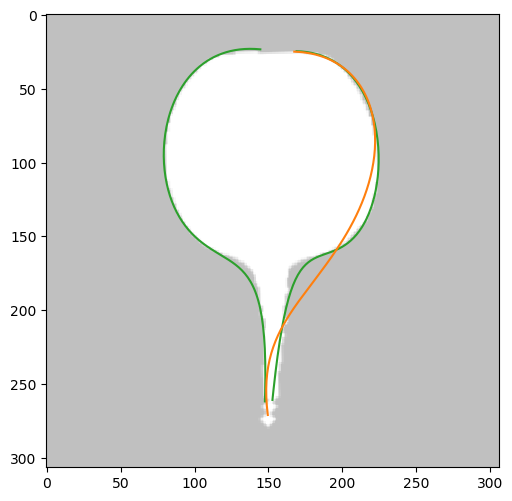

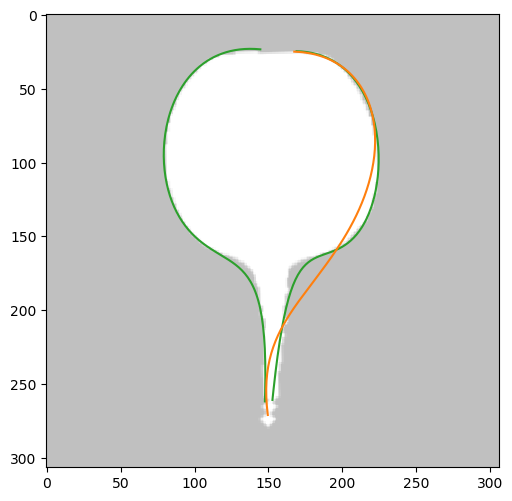

In [13]:
rd.drawBez(img,stt=0.02,end=0.98,bezL=fL1,bezR=fR1,bezC=fR0,ct=list("221456789"))
rd.drawBez(img,stt=0.02,end=0.98,bezL=fL1,bezR=fR1,bezC=fR0,ct=list("2213456789"))

この例は厳密あてはめの方が優れていることが分かりやすい。

これは次数が低いからで、経験的には近似の次数が上がると fit0 と fit1 の差は少なく、大量のデータを処理するなら fit0 でも十分だと思われる。

### 関数式の違い

In [14]:
fL0,fL1,fR0,fR1

(Matrix([
 [147.0*t**4 + 192.551601533388*t**3*(4 - 4*t) + 265.077082808181*t**2*(1 - t)**2 + 175.806130003696*t*(1 - t)**3 + 155.0*(1 - t)**4],
 [ 279.0*t**4 + 162.458984179697*t**3*(4 - 4*t) + 1204.80073305912*t**2*(1 - t)**2 + 1.11597324728571*t*(1 - t)**3 + 25.0*(1 - t)**4]]),
 Matrix([
 [147.0*t**4 + 158.447791405187*t**3*(4 - 4*t) + 477.991192536177*t**2*(1 - t)**2 + 76.6525885660981*t*(1 - t)**3 + 155.0*(1 - t)**4],
 [ 279.0*t**4 + 51.1152315159064*t**3*(4 - 4*t) + 1790.45865944523*t**2*(1 - t)**2 - 25.7957133393588*t*(1 - t)**3 + 25.0*(1 - t)**4]]),
 Matrix([
 [151.0*t**4 + 130.577662073419*t**3*(4 - 4*t) + 1395.67869808753*t**2*(1 - t)**2 + 1083.84412108958*t*(1 - t)**3 + 159.0*(1 - t)**4],
 [ 280.0*t**4 + 163.718975142896*t**3*(4 - 4*t) + 1228.11538060743*t**2*(1 - t)**2 + 68.7998882513331*t*(1 - t)**3 + 25.0*(1 - t)**4]]),
 Matrix([
 [151.0*t**4 + 173.649717563346*t**3*(4 - 4*t) + 1175.73267567909*t**2*(1 - t)**2 + 1170.21569595676*t*(1 - t)**3 + 159.0*(1 - t)**4],
 [  280.0

# Openmode

ベジエ曲線の性質として、曲線は必ず両端の制御点を通る。

そこで、両端の制御点はサンプルの両端であるものとして固定し、両端以外の制御点のみを未知数とすることで、未知数の数を減らしている。

しかし、データとして両端付近はイレギュラーな位置であることが多い。そこで両端を固定せずに未知数としてフィッティングを試みるのが **Openmode** である。

**Openmode** で計算させたい場合は、次のように、 **BezierCurve** のクラス変数 **openmode** の Trueをセットしてから処理を行えばよい。 

In [15]:
rd.BezierCurve.setParameters(openmode=True)

AsymptoticPriority :  distance
dCount    :  7
driftThres:  0.03
errorThres:  0.01
debugmode :  False
openmode  :  True



..............
.....


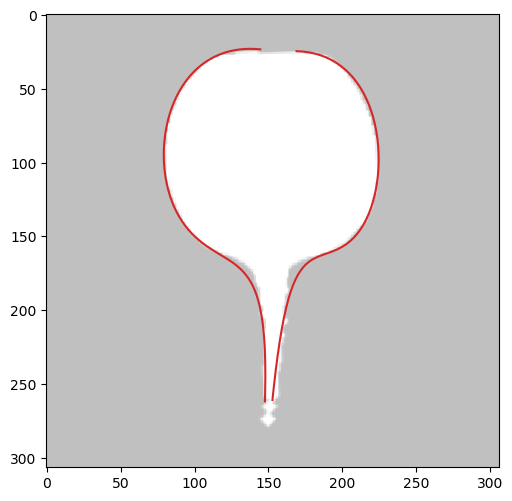

In [16]:
rd.BezierCurve.AsymptoticPriority = 'distance'
cpsL1o,fLo = bezL.fit1()
cpsR1o,fRo = bezR.fit1()
# 結果の描画
rd.drawBez(img,stt=0.02,end=0.98,bezL=fL1,bezR=fR1)

## オープンモードと固定モードの結果比較

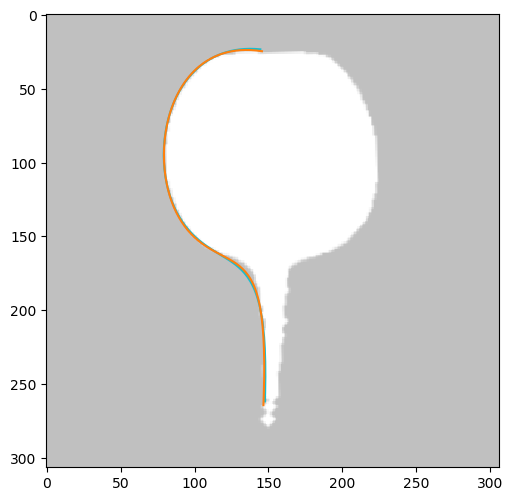

In [17]:
rd.drawBez(img,stt=0.02,end=0.98,bezL=fL1,bezR=fLo,ct=["rikyugreen","orange"])

この例の場合、オープンモード（オレンジ）の上端点は若干内部に回り込んでしまったが、あてはめ的には改善されている。

*stt=0.02,end=0.98* は描画するパラメータ範囲である。つまり、上下２％は描いていない。

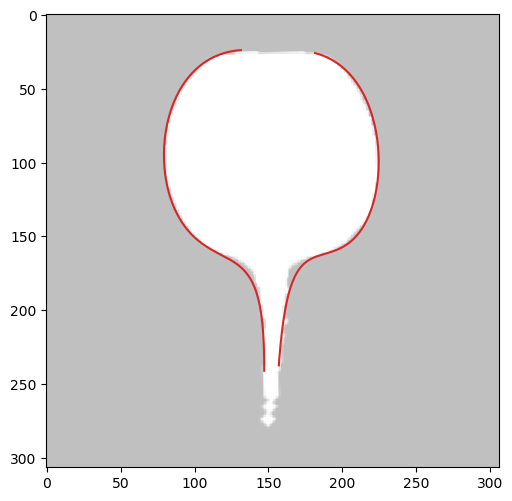

In [18]:
# 両端のカット
rd.drawBez(img,stt=0.05,end=0.95,bezL=fLo,bezR=fRo)

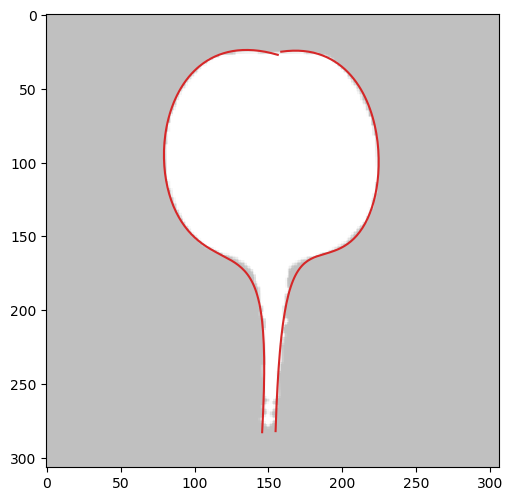

In [19]:
# 両端のカットなし
rd.drawBez(img,stt=0.00,end=1.00,bezL=fLo,bezR=fRo)

# より高次の近似　openmode  高速　８次

AsymptoticPriority :  distance
dCount    :  7
driftThres:  0.03
errorThres:  0.01
debugmode :  False
openmode  :  True





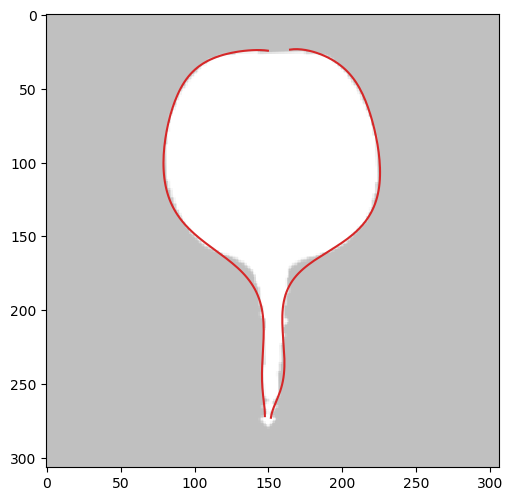

In [20]:
rd.BezierCurve.setParameters(openmode=True)
bezL8 = rd.BezierCurve(N=8,samples=cntL)
bezR8 = rd.BezierCurve(N=8,samples=cntR)
cpsL8,fL8 = bezL8.fit0()
cpsR8,fR8 = bezR8.fit0()
rd.drawBez(img,stt=0.02,end=0.98,bezL=fL8,bezR=fR8)

次数が高いと高速あてはめでも結構きれいに近似できることがわかる。

# より高次の近似　openmode 厳密　８次

.................
..............


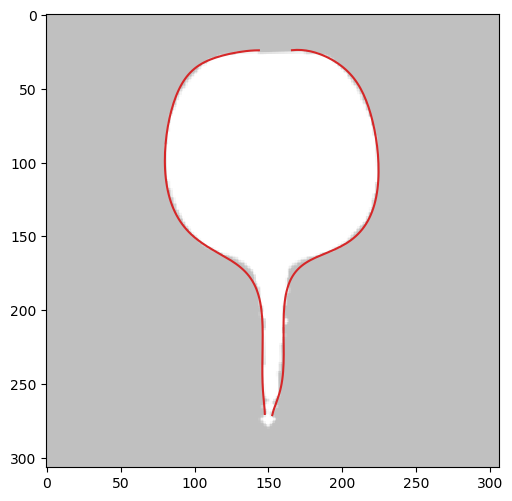

In [21]:
cpsL81,fL81 = bezL8.fit1()
cpsR81,fR81 = bezR8.fit1()
rd.drawBez(img,stt=0.03,end=0.97,bezL=fL81,bezR=fR81)

## 非 openmode 厳密　８次 

AsymptoticPriority :  distance
dCount    :  7
driftThres:  0.03
errorThres:  0.01
debugmode :  False
openmode  :  False

..
.........


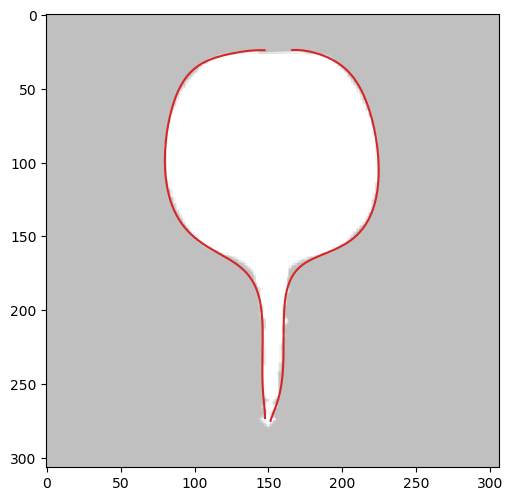

In [22]:
rd.BezierCurve.setParameters(openmode=False)
cpsL8,fL8 = bezL8.fit1()
cpsR8,fR8 = bezR8.fit1()
rd.drawBez(img,stt=0.02,end=0.98,bezL=fL8,bezR=fR8)

# デモ

In [23]:
%%time

def Demo(imgnum,samples=32,N=5,Amode=0,controlPoints=False):
    # 画像の左右の輪郭線を抽出　（S5参照）
    img = imgs[imgnum]
    conLeft,conRight = rd.getCntPairWithImg(img)
    print("輪郭線の画素数は、左 {}  右{}".format(len(conLeft),len(conRight)))
    Left = rd.getSamples(conLeft,N=samples,mode='Equidistant')
    Right = rd.getSamples(conRight,N=samples,mode='Equidistant')
    # 先にもとめた左右の輪郭線からそれぞれ等間隔で32個ずつ標本点を取ってくる
    # ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
    bezL = rd.BezierCurve(N=N,samples=Left)
    bezR = rd.BezierCurve(N=N,samples=Right)
    if Amode == 0:
        # 高速あてはめの実行
        cpsL,fL = bezL.fit0()
        cpsR,fR = bezR.fit0()
    else:
        cpsL,fL = bezL.fit1()
        cpsR,fR = bezR.fit1()
    # 結果の描画
    if controlPoints:
        rd.drawBez(img,stt=0.00,end=1.0,bezL=fL,bezR=fR,cntL=Left,cntR=Right,cpl=cpsL,cpr=cpsR)
    else:
        rd.drawBez(img,stt=0.00,end=1.0,bezL=fL,bezR=fR,cntL=Left,cntR=Right)

Wall time: 0 ns


輪郭線の画素数は、左 302  右300




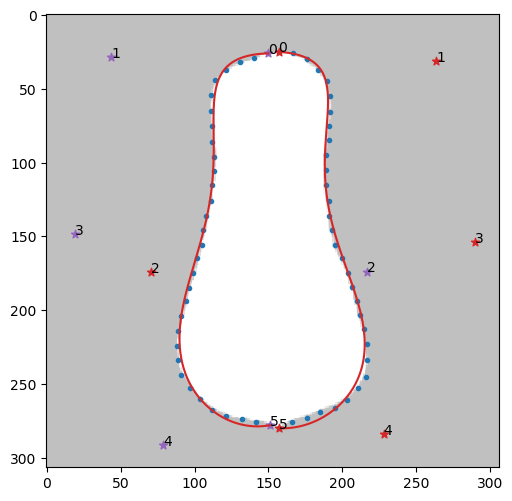

In [24]:
Demo(0,controlPoints=True)

輪郭線の画素数は、左 326  右327




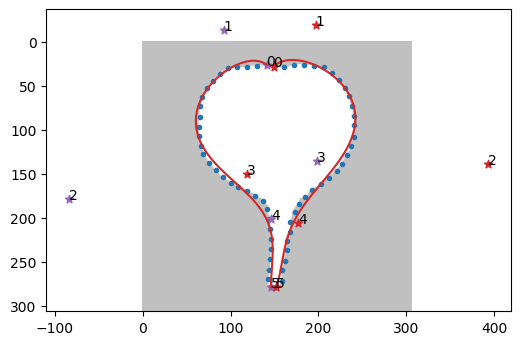

In [25]:
Demo(1,controlPoints=True)

輪郭線の画素数は、左 267  右253




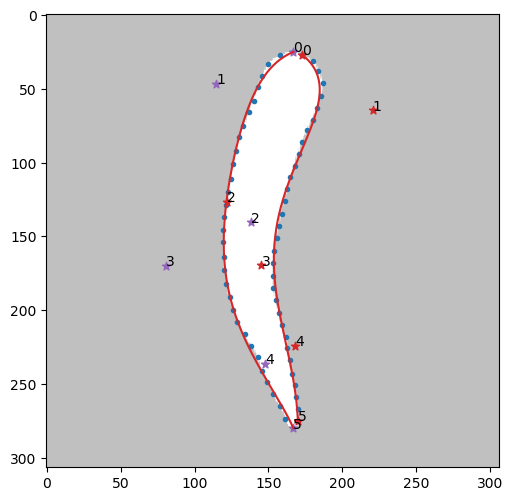

In [26]:
Demo(2,controlPoints=True)

輪郭線の画素数は、左 264  右264




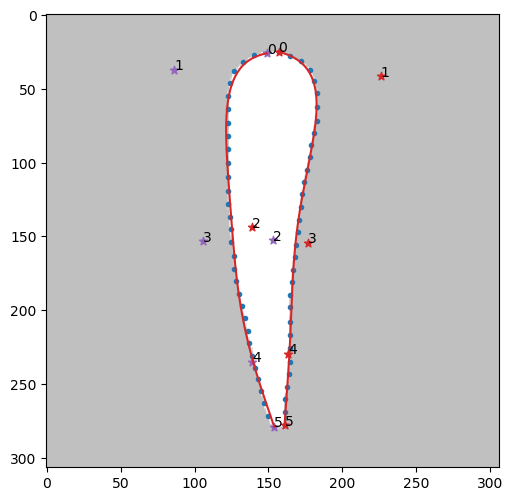

In [27]:
Demo(3,controlPoints=True)

輪郭線の画素数は、左 318  右311




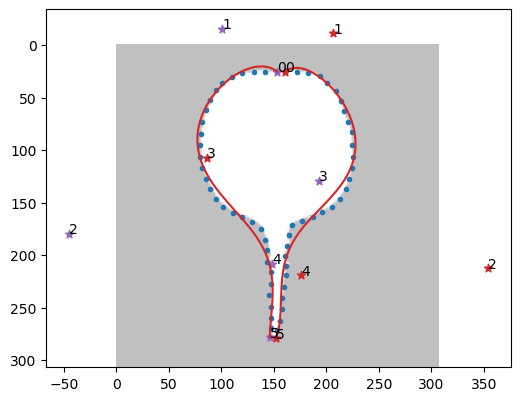

In [28]:
Demo(4,controlPoints=True)

輪郭線の画素数は、左 318  右311




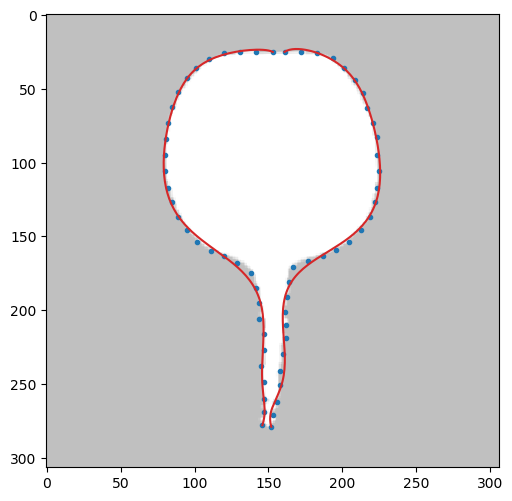

In [29]:
# 8次ベジエ近似
Demo(4,N=8)

輪郭線の画素数は、左 283  右283




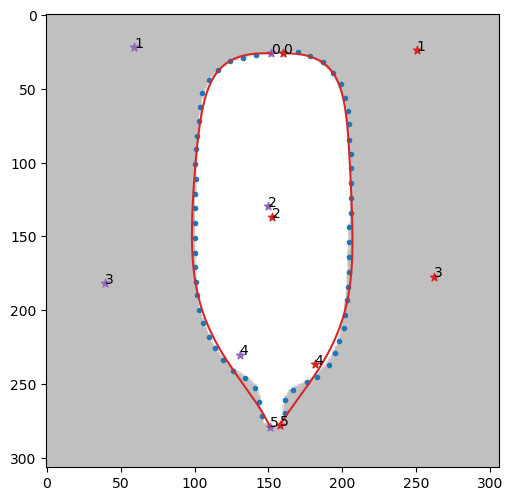

In [30]:
Demo(5,controlPoints=True) #４次

輪郭線の画素数は、左 316  右320




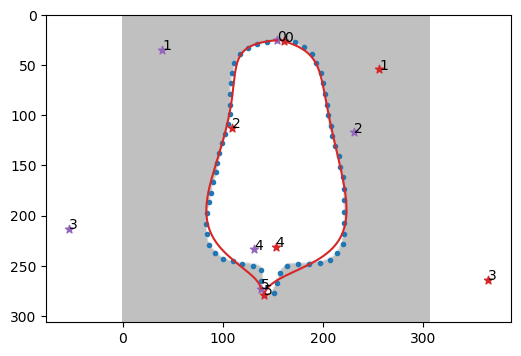

In [31]:
Demo(6,controlPoints=True) #４次

# この個体は５次ベジエの高速あてはめモードではいまいちフィッティングしない。次数を挙げてやればきれいにフィッティングできる。

輪郭線の画素数は、左 316  右320




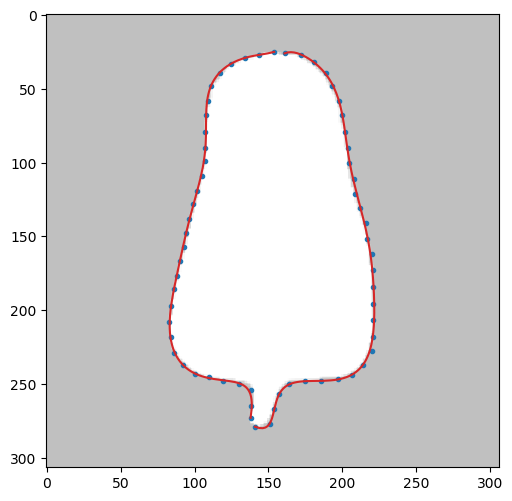

In [32]:
Demo(6,N=12) #12次

輪郭線の画素数は、左 265  右261




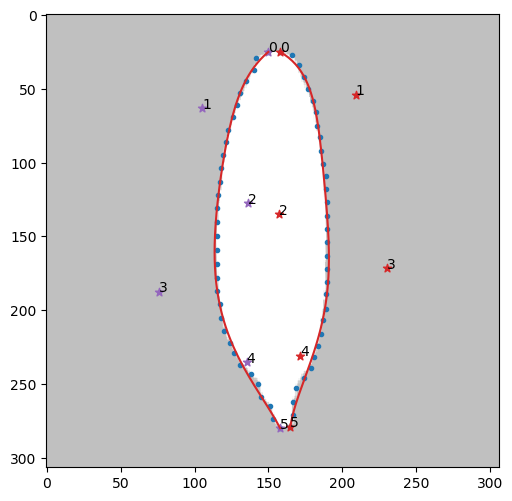

In [33]:
Demo(7,controlPoints=True) # 4次

輪郭線の画素数は、左 263  右263




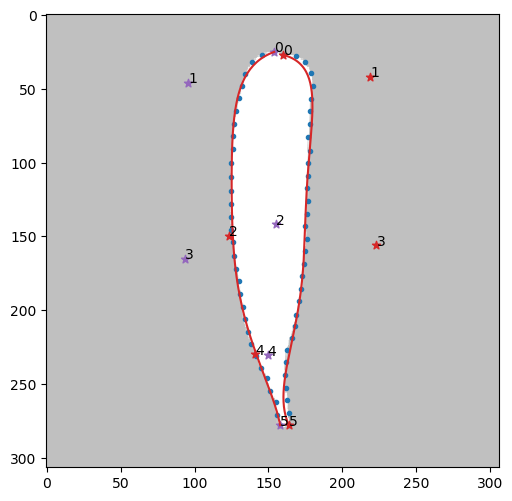

In [34]:
Demo(8,controlPoints=True) # 4次

# Eagerフィッティング

先に、ダルマ型のフィッティングで１２次を使ったが、Eagerフィッティング (fit1) を使えば、低次でもかなりいい線までフィッティングできる。

# ５次 Eager

輪郭線の画素数は、左 316  右320


..............................
....................


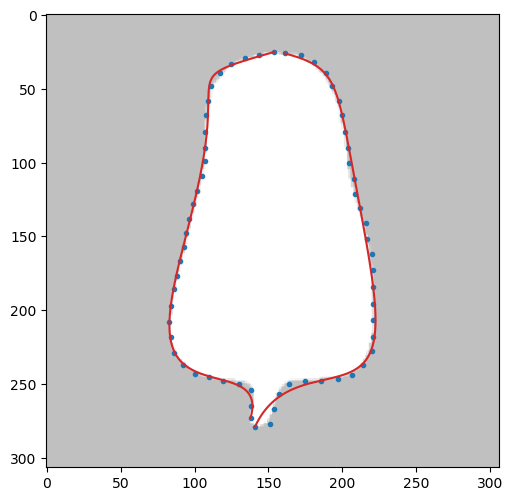

In [35]:
Demo(6,Amode=1,N=5)

# ６次 Eager

輪郭線の画素数は、左 316  右320


.................
.................


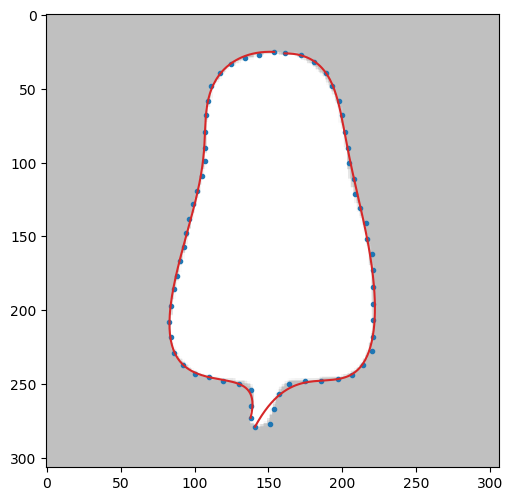

In [36]:
Demo(6,Amode=1,N=6)

低い次数では、尻尾の部分の形までフィッティングするのは困難である。しかし、その部分を近似することに意味はないのでかまわないだろう。

自動化の観点でいえば、問題はそういう部分を自動的にカットするのが難しいという点にある。


# 全周ベジエ近似

上端点を完全自動で求めることは、一般的には困難であるが下端は先細りであることが普通なので、自動検出もそう難しくはない。

下端点を起点かつ終点とする全周の点列を1本のベジエ曲線で近似できるかやってみる。

In [37]:
%%time
def DemoW(imgnum,samples=64,N=10,Amode=0,controlPoints=False):
    # 画像の全周の輪郭線を抽出　（S5参照）
    img = imgs[imgnum]
    conAll = rd.getCntPairWithImg(img, mode=1)
    print("輪郭線の画素数は、{}".format(len(conAll)))
    Samples = rd.getSamples(conAll,N=samples,mode='Equidistant')
    # 先にもとめた左右の輪郭線からそれぞれ等間隔で32個ずつ標本点を取ってくる
    # ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
    bez = rd.BezierCurve(N=N,samples=Samples)
    if Amode == 0:
        # 高速あてはめの実行
        cps,fall = bez.fit0()
    else:
        cps,fall = bez.fit1()
    # 結果の描画
    if controlPoints:
        rd.drawBez(img,stt=0.00,end=1.0,bezL=fall,cntL=Samples,cpl=cps)
    else:
        rd.drawBez(img,stt=0.00,end=1.0,bezL=fall,cntL=Samples)


Wall time: 0 ns


# 高速あてはめ 10次ベジエ

輪郭線の画素数は、608



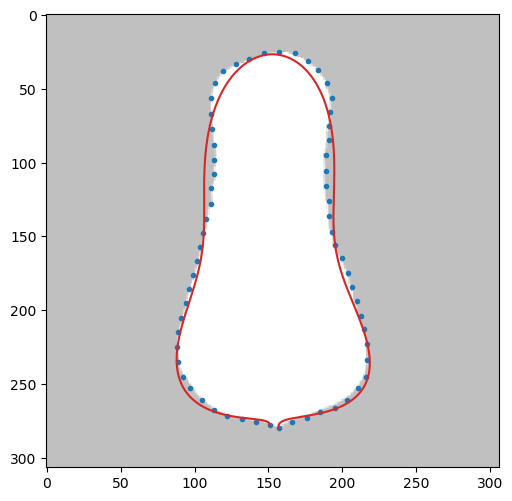

In [38]:
DemoW(0,samples=64,N=10,Amode=0,controlPoints=False)

輪郭線の画素数は、656



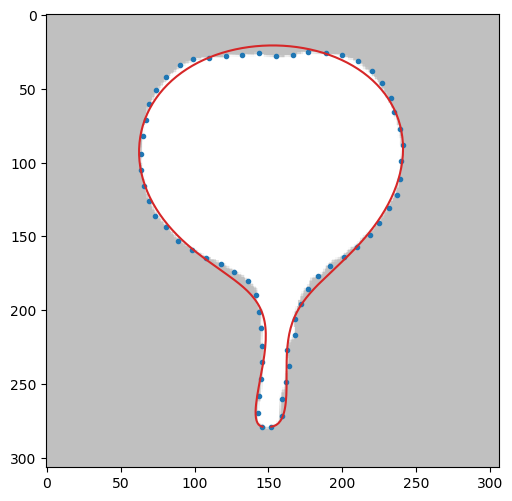

In [39]:
DemoW(1,samples=64,N=10,Amode=0,controlPoints=False)

輪郭線の画素数は、525



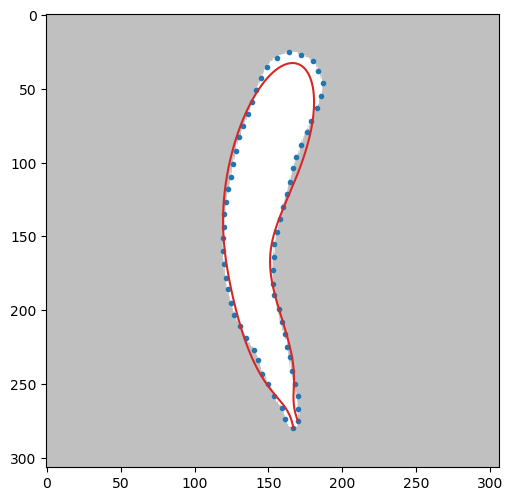

In [40]:
DemoW(2,samples=64,N=10,Amode=0,controlPoints=False)

輪郭線の画素数は、535



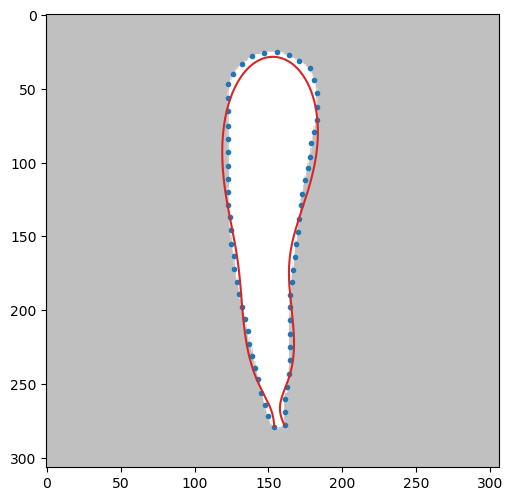

In [41]:
DemoW(3,samples=64,N=10,Amode=0,controlPoints=False)

輪郭線の画素数は、636



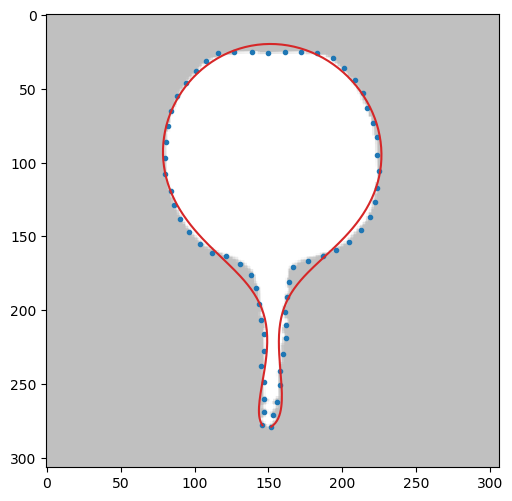

In [42]:
DemoW(4,samples=64,N=10,Amode=0,controlPoints=False)

輪郭線の画素数は、573



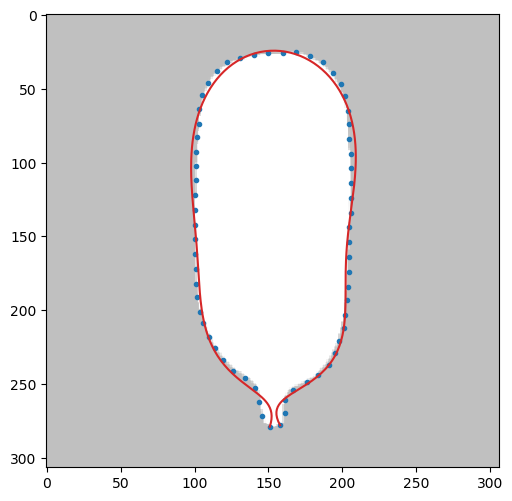

In [43]:
DemoW(5,samples=64,N=10,Amode=0,controlPoints=False)

輪郭線の画素数は、629



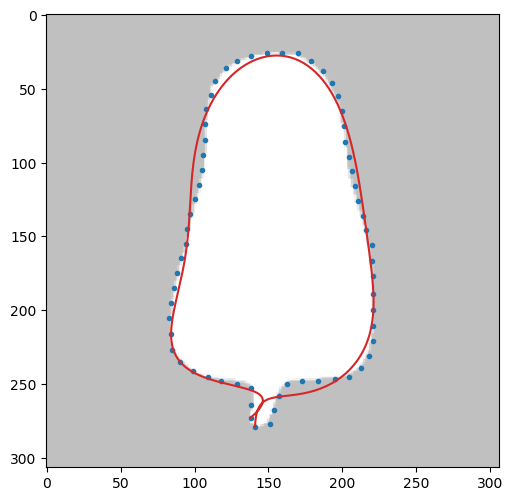

In [44]:
DemoW(6,samples=64,N=10,Amode=0,controlPoints=False)

輪郭線の画素数は、533



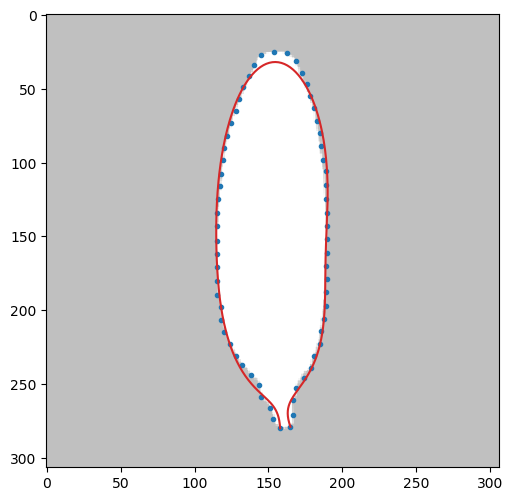

In [45]:
DemoW(7,samples=64,N=10,Amode=0,controlPoints=False)

輪郭線の画素数は、531



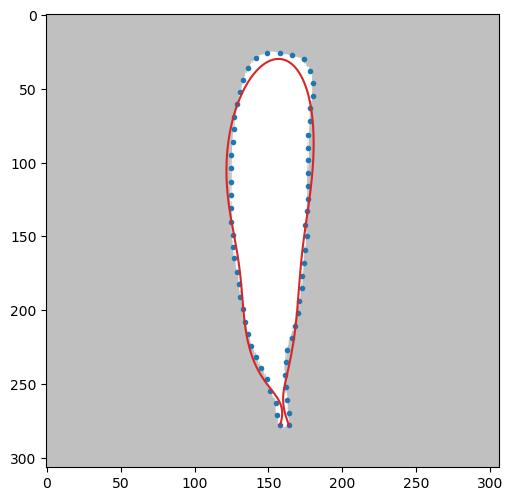

In [46]:
DemoW(8,samples=64,N=10,Amode=0,controlPoints=False)

## 高速モードで15次

輪郭線の画素数は、629



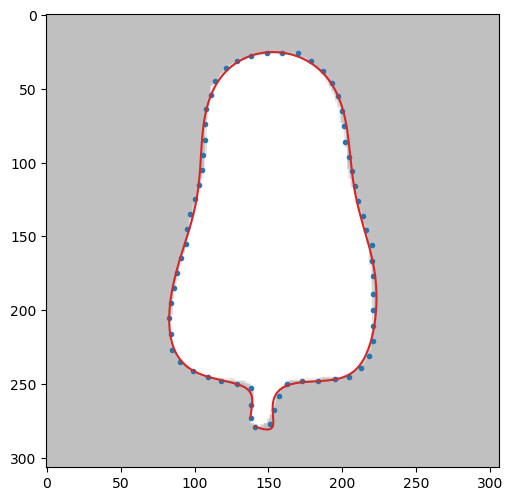

In [47]:
DemoW(6,samples=64,N=15,Amode=0,controlPoints=False)

# Eager フィッティング 10 次

輪郭線の画素数は、629

...........................


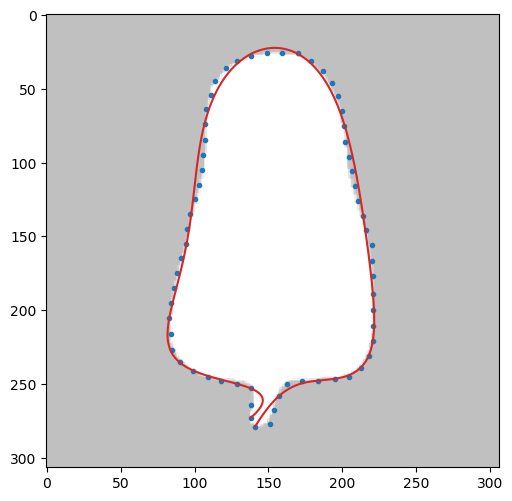

In [48]:
DemoW(6,samples=64,N=10,Amode=1,controlPoints=False)

# Eager フィッティング 12次

輪郭線の画素数は、629

...........


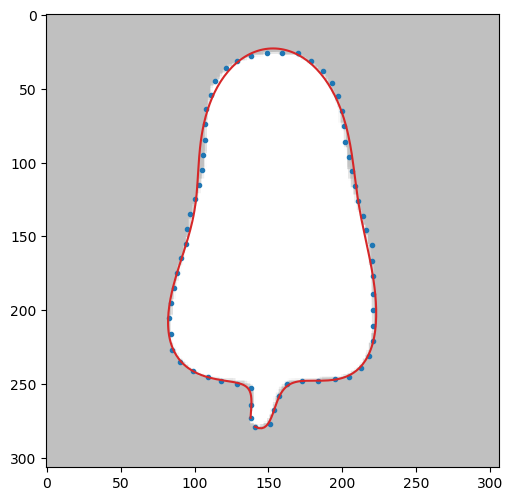

In [49]:
DemoW(6,samples=64,N=12,Amode=1,controlPoints=False)

## 15次

輪郭線の画素数は、629

......


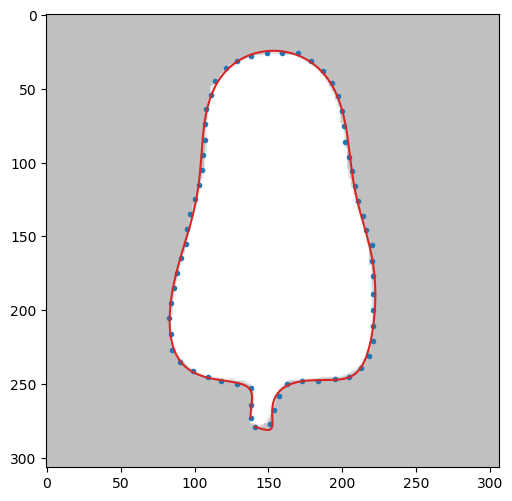

In [50]:
DemoW(6,samples=64,N=15,Amode=1,controlPoints=False)

### 考察
１０次の結果を見ると、端点付近の誤差が大きい。サンプル点付近を通っているが、その間の部分、つまり評価対象外の部分で輪郭から外れており、明らかにオーバーフィッティング気味である。

サンプル点を増やして次数は減らすべきかもしれない。試してみよう。

輪郭線の画素数は、629

.......................
Wall time: 8min 58s


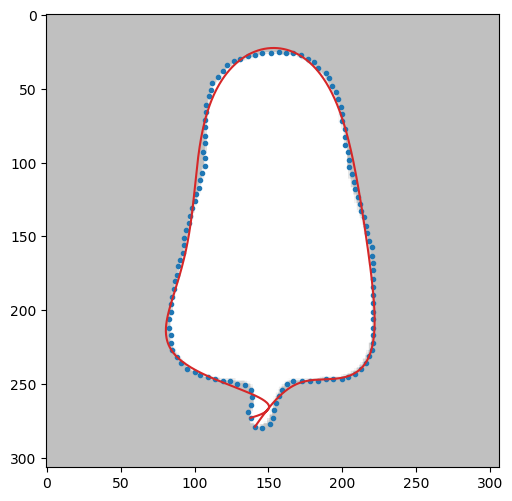

In [51]:
%%time
DemoW(6,samples=128,N=10,Amode=1,controlPoints=False)

# まとめ

- ほとんどの個体の両側は、６次ベジエ曲線まででかなりいい線の近似が可能である。

- 全周を１本のベジエ曲線で近似することも可能である。その場合は、12か13次ぐらいが必要だと思われる。

# 解説は[こちら](https://colab.research.google.com/gist/iciromaco/a39fad822382b65eda0ec6a2e61981cb/s6_-theory-commentary-fitting-beziercurve-to-sample-points.ipynb)

# 備考

## 曲線あてはめの評価尺度について

曲線あてはめに使うあてはめ誤差としては、通常は曲線と標本点の最短距離を用いるのが妥当であろう。
このノートの実験にもその尺度を用いた。

```'rd.BezierCurve.AsymptoticPriority = 'distance'```

は、その尺度を用いるということの宣言である。

これ以外の尺度として、**'span'** を用意した。

**span**を指定した場合は、標本点が等間隔であるということを前提として、標本点と曲線上の最寄り点との距離の代わりに、曲線上に等間隔に採った点との距離を評価尺度とする。

例として、

```
[[100,100],[100,120],[100,140],[100,160],[100,180],[120,180],[140,180],[160,180],[180,180]]
```

という点列を使って結果を比べてみよう、

### distance


.............


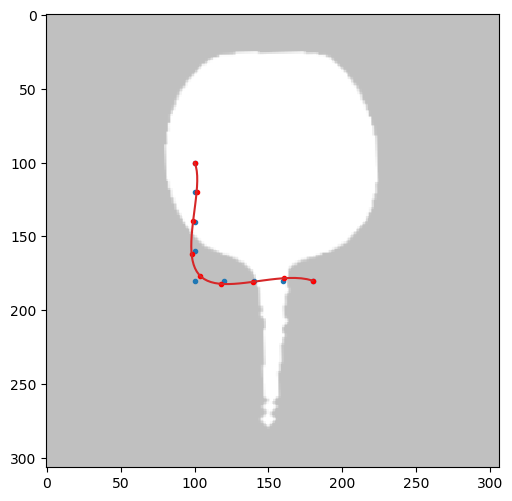

In [52]:
rd.BezierCurve.debugmode = False
test = np.array([[100,100],[100,120],[100,140],[100,160],[100,180],[120,180],[140,180],[160,180],[180,180]])
rd.BezierCurve.AsymptoticPriority = 'distance'
bez = rd.BezierCurve(N=4,samples=test)
cps,f = bez.fit1()
cps,f = bez.fit0(bez.ts)
rd.drawBez(img,stt=0.00,end=1.0,bezL=f,cntL=test[::-1])
tl = bez.ts
flx,fly = f
setlx = [float(flx.subs('t',s)) for s in tl]
setly = [float(fly.subs('t',s)) for s in tl]
plt.scatter(setlx,setly,marker='.',color='red')

### span


....................


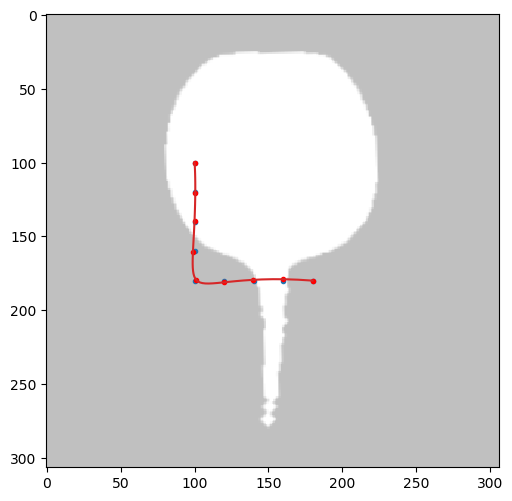

In [53]:
rd.BezierCurve.debugmode = False
test = np.array([[100,100],[100,120],[100,140],[100,160],[100,180],[120,180],[140,180],[160,180],[180,180]])
rd.BezierCurve.AsymptoticPriority = 'span'
bez = rd.BezierCurve(N=4,samples=test)
cps,f = bez.fit1()
cps,f = bez.fit0(bez.ts)
rd.drawBez(img,stt=0.00,end=1.0,bezL=f,cntL=test[::-1])
tl = bez.ts
flx,fly = f
setlx = [float(flx.subs('t',s)) for s in tl]
setly = [float(fly.subs('t',s)) for s in tl]
plt.scatter(setlx,setly,marker='.',color='red')

この例では明らかに span の方があてはめ精度が高い。

ただダイコンのシルエットをいくつか試した限りでは、span は大きな歪を生じることが多かった。